In [1]:
!pip install --upgrade dagshub mlflow imbalanced-learn

In [18]:
!pip install dagshub

In [19]:
import dagshub
dagshub.init(repo_owner='alaki22', repo_name='Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e632a709-250a-4a4b-a17e-fc50d572e32a&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9816f9c54be08025dc8bbfcf72d786b52a9236b02366988ed26f6107dd47afdb




Output()

Accessing as alaki22

Initialized MLflow to track repo "alaki22/Fraud-Detection"

Repository alaki22/Fraud-Detection initialized!

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
import pandas as pd

train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
train_identity = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")

train_df = train_transaction.merge(train_identity, on="TransactionID", how="left")

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', None)

In [5]:
y = train_df['isFraud']
X = train_df.drop(columns = ['isFraud'])

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)


X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (413378, 433)
Validation size: (88581, 433)
Test size: (88581, 433)


Feature Engineering

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class FraudDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 nan_threshold=0.95,
                 flag_threshold=0.1,
                 num_strategy='median', 
                 cat_strategy='most_frequent'):
        self.nan_threshold = nan_threshold
        self.flag_threshold = flag_threshold
        self.num_strategy = num_strategy
        self.cat_strategy = cat_strategy
        self.columns_to_drop_ = []
        self.impute_values_ = {}
        self.flags_to_add_ = []

    def fit(self, X, y=None):
       
        na_ratios = X.isna().mean()
        self.columns_to_drop_ = na_ratios[na_ratios >= self.nan_threshold].index.tolist()
        print(self.columns_to_drop_)
        
        
        remaining_cols = [c for c in X.columns if c not in self.columns_to_drop_]
        num_cols = X[remaining_cols].select_dtypes(include='number').columns
        cat_cols = X[remaining_cols].select_dtypes(exclude='number').columns
        
        for col in num_cols:
            self.impute_values_[col] = X[col].median() if self.num_strategy == 'median' else X[col].mean()
            
        for col in cat_cols:
            mode = X[col].mode()
            self.impute_values_[col] = mode[0] if not mode.empty else 'MISSING'
            
        return self

    def transform(self, X):
        X = X.copy()
        
        cols_to_drop = [col for col in self.columns_to_drop_ if col in X.columns]
        X = X.drop(columns=cols_to_drop)
    
        for col, val in self.impute_values_.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
                
        return X

  

In [8]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder


class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 3):
        self.threshold = threshold
        self.woe_mappings = {}
        self.target_encodings = {}
        self.ohe = None
        
    def fit(self, X, y=None):
        df = X.copy()

        cat_cols = [col for col in df.columns if df[col].dtype == 'object']
        num_cols = [col for col in df.columns if df[col].dtype != 'object']
        
        
        n_unique = df[cat_cols].nunique()
        na_rate = df[cat_cols].isna().mean()

        self.woe_columns = list(n_unique[(n_unique > self.threshold) & (na_rate <= 0.5)].index)
        self.one_hot_columns = list(n_unique[(n_unique <= self.threshold) & (na_rate <= 0.5)].index)
        
        df['__target__'] = y

       

        # --- WOE ENCODING ---
        self.woe_columns_fill_na = {
            col: X[col].mode().iloc[0] if not X[col].mode().empty else 'missing'
            for col in self.woe_columns
        }
        
        self.woe_mappings = {}
        for col in self.woe_columns:
            groups = df.groupby(col)['__target__'].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            self.woe_mappings[col] = groups['woe'].to_dict()


        # --- ONE-HOT ENCODER ---
        self.ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, dtype=int)
        self.ohe.fit(X[self.one_hot_columns])

        return self

    def transform(self, X):
        X_transformed = X.copy()


        # --- Apply WOE ---
        for col in self.woe_columns:
            X_transformed[f'{col}_woe'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)


        print("Check Nans")
        n = X_transformed.isna().mean()

        na_cols = list(n[n > 0].index)

        print(na_cols)

        for col in na_cols:
            name, pr = col.rsplit("_", 1)
            if pr != "woe":
                print("Error Related to Nans")

            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])


        # --- Apply One-Hot Encoding ---
        ohe_array = self.ohe.transform(X[self.one_hot_columns])
        ohe_columns = self.ohe.get_feature_names_out(self.one_hot_columns)
        df_ohe = pd.DataFrame(ohe_array, columns=ohe_columns, index=X.index)

        X_transformed.drop(columns=self.one_hot_columns, inplace=True)
        X_transformed = pd.concat([X_transformed, df_ohe], axis=1)

        return X_transformed


Feature Selection

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_drop_ = []

    def fit(self, X, y=None):
        corr_matrix = pd.DataFrame(X).corr().abs()
        high_corr_pairs = [
            (corr_matrix.columns[i], corr_matrix.columns[j])
            for i in range(len(corr_matrix.columns))
            for j in range(i + 1, len(corr_matrix.columns))
            if corr_matrix.iloc[i, j] > self.threshold
        ]
        
        features_to_drop = []
        for feat1, feat2 in high_corr_pairs:
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                features_to_drop.append(feat1)
            else:
                features_to_drop.append(feat2)
        
        self.features_to_drop_ = list(set(features_to_drop))
        return self

    def transform(self, X):
        print(self.features_to_drop_)
        return X.drop(columns=self.features_to_drop_, errors='ignore')


Training

In [27]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report


pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,      
        flag_threshold=0.05,     
        num_strategy='median',  
        cat_strategy='most_frequent'
    )),  
    ('custom_encoding', CustomPreprocessor(threshold=3)), 
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)), 
    ('classifier', LogisticRegression(
        solver='liblinear',
        class_weight='balanced',  
        random_state=42
    ))  
])


pipeline.fit(X_train, y_train)

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)


print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")


print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126', 'V251', 'V146', 'V16', 'id_15_New', 'V92', 'V212', 'V194', 'V203', 'V102', 'V30

Train ROC AUC: 0.7881
Validation ROC AUC: 0.7861
Test ROC AUC: 0.7920
Train F1 Score: 0.1846
Validation F1 Score: 0.1870
Test F1 Score: 0.1915

2025/04/27 13:42:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


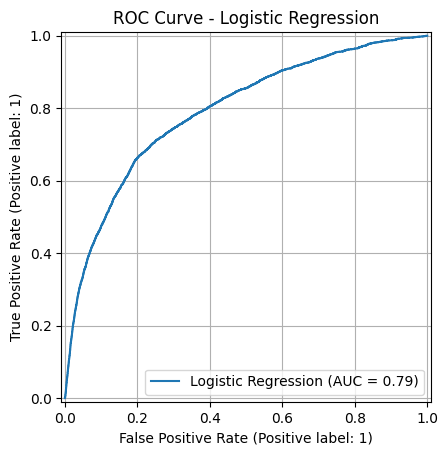

🏃 View run logistic_regression_without_scaler at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2/runs/3afdc5934bef4f818f5be49905cdf7db
🧪 View experiment at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2


In [28]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("logistic_regression")  
with mlflow.start_run(run_name="logistic_regression_without_scaler"):
    mlflow.sklearn.log_model(
        sk_model=pipeline,          
        artifact_path="model",      
        registered_model_name=None   
    )
    

    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)


    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_proba, 
        name="Logistic Regression"
    )

    
    plt.title('ROC Curve - Logistic Regression')
    plt.grid()
    plt.savefig('roc_curve.png')  
    
    
    mlflow.log_artifact('roc_curve.png')  

    plt.show()


In [17]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler


pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,      
        flag_threshold=0.05,     
        num_strategy='median',   
        cat_strategy='most_frequent'
    )),  
    ('custom_encoding', CustomPreprocessor(threshold=3)), 
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)),  
    ('scaler', StandardScaler()), 
    ('classifier', LogisticRegression(
        solver='liblinear', 
        max_iter=1000,       
        class_weight='balanced',
        random_state=42
    ))  
])


pipeline.fit(X_train, y_train)


y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]


y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)


roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)


print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")


print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126

===== Model Performance (ROC AUC and F1 Score) =====
Train ROC AUC: 0.8596

Validation ROC AUC: 0.8567

Test ROC AUC: 0.8563

Train F1 Score: 0.2253

Validation F1 Score: 0.2292

Test F1 Score: 0.2288

2025/04/27 13:33:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


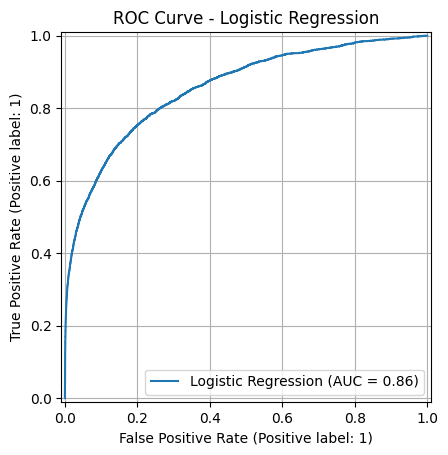

🏃 View run logistic_regression_with_scaler at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2/runs/8d48939068b2490db67eb36778785fc9
🧪 View experiment at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2


In [25]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("logistic_regression")  
with mlflow.start_run(run_name="logistic_regression_with_scaler"):
    mlflow.sklearn.log_model(
        sk_model=pipeline,           
        artifact_path="model",       
        registered_model_name=None   
    )
    
    
    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)


    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_proba, 
        name="Logistic Regression"
    )

  
    plt.title('ROC Curve - Logistic Regression')
    plt.grid()
    plt.savefig('roc_curve.png')  
    
   
    mlflow.log_artifact('roc_curve.png')  

    plt.show()


In [29]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report


pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,      
        flag_threshold=0.05,     
        num_strategy='median',   
        cat_strategy='most_frequent'
    )), 
    ('custom_encoding', CustomPreprocessor(threshold=3)),  
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)),  
    ('undersampling', RandomUnderSampler(random_state=42)), 
    ('classifier', LogisticRegression(
        solver='liblinear',     
        class_weight='balanced',
        random_state=42
    ))  
])


pipeline.fit(X_train, y_train)


y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]


y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)


roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)


print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")


print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126', 'V251', 'V146', 'V16', 'id_15_New', 'V92', 'V212', 'V194', 'V203', 'V102', 'V30

===== Model Performance (ROC AUC and F1 Score) =====
Train ROC AUC: 0.8035
Validation ROC AUC: 0.8023
Test ROC AUC: 0.8074

2025/04/27 13:53:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


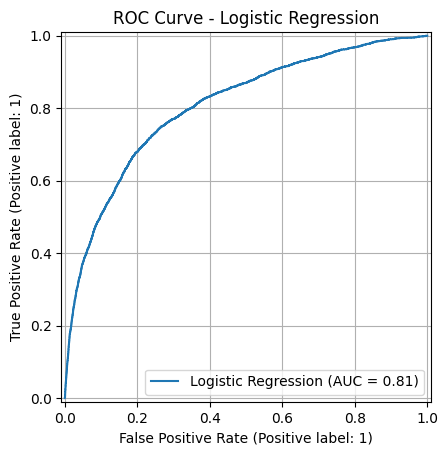

🏃 View run logistic_regression_with_scaler at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2/runs/2b0b3cb6a0764a34a6b44862eaa2c873
🧪 View experiment at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2


In [30]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("logistic_regression")  
with mlflow.start_run(run_name="logistic_regression_with_undersampling"):
    mlflow.sklearn.log_model(
        sk_model=pipeline,           
        artifact_path="model",       
        registered_model_name=None   
    )
    
    
    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)


    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_proba, 
        name="Logistic Regression"
    )

  
    plt.title('ROC Curve - Logistic Regression')
    plt.grid()
    plt.savefig('roc_curve.png')  
    
   
    mlflow.log_artifact('roc_curve.png')  

    plt.show()


In [33]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE



pipeline = ImbPipeline([
    ('preprocessor', FraudDataPreprocessor(
        nan_threshold=0.95,     
        flag_threshold=0.05,     
        num_strategy='median',   
        cat_strategy='most_frequent'
    )),  
    ('custom_encoding', CustomPreprocessor(threshold=3)),  
    ('correlation_drop', CorrelationFeatureDropper(threshold=0.8)), 
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(
        solver='liblinear', 
        max_iter=1000,      
        class_weight='balanced', 
        random_state=42
    ))  
])


pipeline.fit(X_train, y_train)

y_train_proba = pipeline.predict_proba(X_train)[:, 1]
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_test_proba = pipeline.predict_proba(X_test)[:, 1]


y_train_pred = (y_train_proba > 0.5).astype(int)
y_val_pred = (y_val_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

roc_auc_train = roc_auc_score(y_train, y_train_proba)
roc_auc_val = roc_auc_score(y_val, y_val_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)


print("\n===== Model Performance (ROC AUC and F1 Score) =====")
print(f"Train ROC AUC: {roc_auc_train:.4f}")
print(f"Validation ROC AUC: {roc_auc_val:.4f}")
print(f"Test ROC AUC: {roc_auc_test:.4f}")

print(f"Train F1 Score: {f1_train:.4f}")
print(f"Validation F1 Score: {f1_val:.4f}")
print(f"Test F1 Score: {f1_test:.4f}")


print("\n===== Test Set Classification Report =====")
print(classification_report(y_test, y_test_pred))


['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
Check Nans
[]
['V49', 'V116', 'V129', 'V313', 'D2', 'V57', 'V331', 'V39', 'V125', 'V74', 'V94', 'V292', 'C10', 'V218', 'V298', 'V127', 'V134', 'V33', 'V8', 'V105', 'V24', 'V51', 'V204', 'V328', 'V13', 'V182', 'V159', 'V60', 'V36', 'C11', 'V37', 'V44', 'V196', 'V248', 'V336', 'id_17', 'V329', 'V132', 'V215', 'V300', 'V32', 'V31', 'V90', 'V307', 'V176', 'V93', 'V133', 'V22', 'V291', 'C1', 'V119', 'V334', 'C13', 'V308', 'V221', 'V128', 'V272', 'V279', 'V61', 'V185', 'V21', 'V96', 'V337', 'V130', 'V72', 'C14', 'V330', 'V244', 'V156', 'V246', 'V288', 'V332', 'V267', 'V255', 'V59', 'V311', 'V11', 'V299', 'V79', 'V157', 'V190', 'V136', 'V18', 'V71', 'V80', 'V275', 'V25', 'C12', 'V85', 'V103', 'V206', 'V139', 'V338', 'V43', 'V163', 'V160', 'V135', 'V294', 'V303', 'V198', 'V4', 'C6', 'V202', 'V326', 'V317', 'V82', 'V233', 'V168', 'V256', 'V322', 'V73', 'id_16_NotFound', 'V86', 'V172', 'V236', 'V225', 'V243', 'V126

Train ROC AUC: 0.8015
Validation ROC AUC: 0.7998
Test ROC AUC: 0.8047

2025/04/27 14:11:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


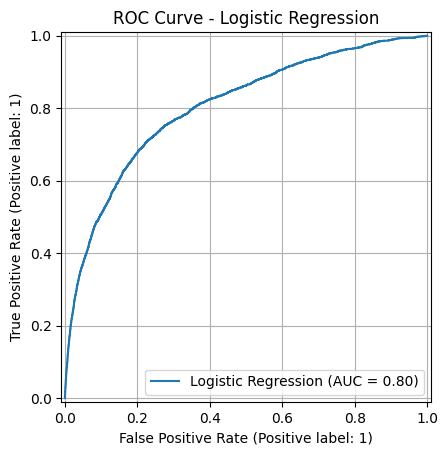

🏃 View run logistic_regression_with_oversampling at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2/runs/d2af64bdd50a4fb3b508c4e88733d18e
🧪 View experiment at: https://dagshub.com/alaki22/Fraud-Detection.mlflow/#/experiments/2


In [34]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment("logistic_regression")  
with mlflow.start_run(run_name="logistic_regression_with_oversampling"):
    mlflow.sklearn.log_model(
        sk_model=pipeline,           
        artifact_path="model",       
        registered_model_name=None   
    )
    
    
    mlflow.log_metric("roc_auc_train", roc_auc_train)
    mlflow.log_metric("roc_auc_val", roc_auc_val)
    mlflow.log_metric("roc_auc_test", roc_auc_test)


    RocCurveDisplay.from_predictions(
        y_test, 
        y_test_proba, 
        name="Logistic Regression"
    )

  
    plt.title('ROC Curve - Logistic Regression')
    plt.grid()
    plt.savefig('roc_curve.png')  
    
   
    mlflow.log_artifact('roc_curve.png')  

    plt.show()
